# Introduction to NLP Fundamentals in Tensorflow

Natural Language Process (NLP) is the technology used to aid computers to undestand human's natural language. (could be sequences text or speech)

Another common term for NLP problem is sequence to sequence problems (seq2seq).

In [2]:
# Import libraries
import random
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from sklearn.model_selection import train_test_split

print(f'Tensorflow Version: {tf.__version__}')

Tensorflow Version: 2.12.0


## Check for GPU

In [3]:
!nvidia-smi -L

/bin/bash: line 1: nvidia-smi: command not found


## Get the helper function and import some functions

In [5]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_histories

## Get a text dataset

The dataset we're going to be using is Kaggle's introduction to NLP dataset (text samples of Tweets labelled as diaster or not diaster)

Kaggle source here for competition: https://www.kaggle.com/competitions/nlp-getting-started

In [6]:
# Download data as zip
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

--2023-08-24 15:12:03--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.210.128, 173.194.211.128, 173.194.212.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.210.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.02s   

2023-08-24 15:12:04 (32.1 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



In [7]:
# Unzip data
zip_ref = zipfile.ZipFile('nlp_getting_started.zip')
zip_ref.extractall()
zip_ref.close()

## Becoming one with the data

We got the data and now, we need to understand our data that's wht lets visualize the text data.

In [8]:
# Read the data and turn it pandas dataframe
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [9]:
# Check out the first 5 row
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [10]:
# Get the info from train dataset
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [11]:
# Check the text row
train_df['text'][1]

'Forest fire near La Ronge Sask. Canada'

In [12]:
# Shuffle train data
train_df_shuffled = train_df.sample(frac=1, random_state=42)

In [13]:
# Check the shuffled data
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [14]:
# How does look like test data?
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [15]:
# How many examples of each class?
train_df_shuffled['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [16]:
# How many total samples?
print(f'Train total samples: {len(train_df_shuffled)}')
print(f'Test total samples: {len(test_df)}')

Train total samples: 7613
Test total samples: 3263


In [17]:
# Let's visualize the some random training examples
random_samples = random.sample(range(0, len(train_df_shuffled)), 5)

for i in random_samples:
    target = train_df_shuffled['target'][i]
    text = train_df_shuffled['text'][i]
    print(f'Target: {target}', '(Real Diaster)' if target == 1 else '(Not Real Diaster)')
    print(f'Text: {text}', '\n')

Target: 1 (Real Diaster)
Text: Salem 2 nuclear reactor shut down over electrical circuit failure on pump http://t.co/LQjjy1PTWT 

Target: 1 (Real Diaster)
Text: @ictyosaur I never thought it would be a wtf moment yet it's here after months of 90 degree heat
Next we will have flash floods.. 

Target: 0 (Not Real Diaster)
Text: A grade in Black Horse Famine[MEGA]. Score 0840728
http://t.co/pdiit0AF3Q
#Dynamix http://t.co/ZQ5KDOx7BY 

Target: 0 (Not Real Diaster)
Text: ng2x5 mhtw4fnet

Watch Michael Jordan absolutely destroy this meme-baiting camper - FOXSportscom 

Target: 0 (Not Real Diaster)
Text: @alexbelloli well now I know lol 



### Split data into training and validation sets

In [18]:
# Use train_test_split to split our data
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled['text'].to_numpy(),
                                                                            train_df_shuffled['target'].to_numpy(),
                                                                            test_size=0.1,
                                                                            random_state=42)

In [19]:
# Check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [20]:
# Check the first 10 samples
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

## Converting text into numbers

When dealing with a text problem, one of the first things you'll have to do before build a model is to convert text into the numbers.

There are few ways to do this:
* Tokenization - direct mapping of token (a token could be a word or a characher) to number
* Embedding - create a matrix of feature vektor for each token (the size of the feature vektor can be defined and this embedding can be learned)

### Text vektorization (tokenization)

TensorFlow Vectorization Docs: https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization

In [21]:
# Use the default text vektorization parameters
text_vektorizer = TextVectorization(max_tokens=None, # How many words in the sentence (automatically add <OOV> OOV:Out of word)
                                    standardize='lower_and_strip_punctuation', # lower case the word and delete punctuations
                                    split='whitespace', # Split the sentence with whitespace
                                    ngrams=None, # Create groups of n-words?
                                    output_mode='int', # How to map tokens to numbers
                                    output_sequence_length=None, # How long do you want your sequences to be?
                                    pad_to_max_tokens=False)

In [22]:
# Find the average number of tokens (words) in the training tweets
total_words = sum([len(i.split()) for i in train_sentences])
total_sentences = len(train_sentences)
round(total_words / total_sentences)

15

In [23]:
# Setup text vectorization variables
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15 # max length our sequences will be (e.g. how many words from a Tweet does a model see)

text_vektorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode='int',
                                    output_sequence_length=max_length,
                                    pad_to_max_tokens=True)

In [24]:
# Fit the text vectorizer to the training text
text_vektorizer.adapt(train_sentences)

In [25]:
# Create a sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vektorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [26]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print('Random sentence:\n', random_sentence, '\n')
print('Vectorized version:\n', text_vektorizer([random_sentence]))

Random sentence:
 Stu put beetroot in his cake and even lost to a mudslide 

Vectorized version:
 tf.Tensor(
[[4515  370    1    4   79  960    7  151  681    5    3  456    0    0
     0]], shape=(1, 15), dtype=int64)


In [27]:
# Get the unique words in the vocabulary
words_in_vocab = text_vektorizer.get_vocabulary()
top_5_words = words_in_vocab[:5]
bottom_5_words = words_in_vocab[-5:]
print(f'Number of words in vocabulary: {len(words_in_vocab)}')
print(f'5 most common words: {top_5_words}')
print(f'5 least common words: {bottom_5_words}')

Number of words in vocabulary: 10000
5 most common words: ['', '[UNK]', 'the', 'a', 'in']
5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


### Creating an Embedding using Embedding layer

Tensorflow Embedding Docs: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding

The parameters we mostly care about the Embedding layer:
* `input_dim` = the size of our vocabulary
* `output_dim` = the size of the output embedding vector, for example, a value of 100 would mean each token gets represented by a vector 100 long
* `input_length` = length of the sequences being passed to the embedding layer

In [28]:
embedding = tf.keras.layers.Embedding(input_dim=max_vocab_length, # set input shape
                                      output_dim=128,
                                      input_length=max_length) # how long is each input
embedding

In [29]:
# Get a random sentence form the training set
random_sentence = random.choice(train_sentences)
print(f'Random sentence:\n', random_sentence, '\n')

# Embed the random sentence (turn it into dense vectors of fixed size)
sample_embed = embedding(text_vektorizer([random_sentence]))
print(f'Embedding version:\n', sample_embed)

Random sentence:
 Today was trauma on top of trauma on top of  trauma in Richmond so I know work is going to be crazy the next two days 

Embedding version:
 tf.Tensor(
[[[-0.02645898  0.02813125 -0.01841486 ...  0.03466851  0.00695112
    0.00316787]
  [ 0.00726604  0.01863505 -0.02948855 ...  0.0283593   0.01674974
   -0.01258248]
  [ 0.0173097   0.041047   -0.0179628  ...  0.04084933  0.01003026
    0.03462411]
  ...
  [-0.02463075 -0.01644982  0.03898635 ...  0.0373992  -0.0097791
   -0.0165521 ]
  [ 0.03256733  0.0006303  -0.03389265 ... -0.03463584  0.01646323
   -0.04591395]
  [-0.0034351   0.01439846 -0.02842211 ... -0.00120876  0.01871491
   -0.00510129]]], shape=(1, 15, 128), dtype=float32)


In [30]:
# Check out the single token's embedding
random_sentence, sample_embed[0][0], sample_embed[0][0].shape

('Today was trauma on top of trauma on top of  trauma in Richmond so I know work is going to be crazy the next two days',
 <tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([-2.64589787e-02,  2.81312503e-02, -1.84148550e-02,  3.76040377e-02,
        -4.03546318e-02, -3.36159244e-02,  2.69805081e-02, -2.78275851e-02,
         3.76790799e-02,  2.08400600e-02, -3.11544184e-02,  1.13967881e-02,
        -2.45567802e-02, -3.07153948e-02, -4.05165069e-02, -1.49526112e-02,
        -1.60595290e-02,  3.58355977e-02,  4.67105843e-02, -4.64918502e-02,
         3.30007337e-02,  1.27024315e-02, -2.77713537e-02,  2.12464444e-02,
         3.27247865e-02, -1.70960315e-02,  5.47351688e-03,  4.34593111e-03,
         9.64522362e-04,  7.84121454e-04,  3.74902226e-02,  4.12990935e-02,
         1.02262124e-02, -6.75297901e-03,  4.19059284e-02, -3.51041444e-02,
        -1.20148174e-02, -3.72551307e-02, -1.17886811e-04,  3.90946865e-04,
         4.62324508e-02,  1.68952011e-02,  4.36547287e-02,  2.3795578

## Modelling a text dataset (running a series of experiments)

We converted our text data into numbers with vectorization and embedding, now it is time to create models. Here are the models we will create step by step:

* Model 0: [Naive Bayes](https://scikit-learn.org/stable/modules/naive_bayes.html) with TF-IDF encoder (baseline)
* Model 1: Feed-forward neural network (dense model)
* Model 2: LSTM model (RNN)
* Model 3: GRU model (RNN)
* Model 4: Bidirectional-LSTM model (RNN)
* Model 5: 1D Convolutional neural network
* Model 6: TensorFlow Hub pretrained feature extractor
* Model 7: Same as model 6 with 10% of training data

Standard steps in the modelling with tensorflow:
* Create a model
* Compile the model
* Fit the mdel
* Evaluate the model
* Improve through experimentation

### Modeling 0: Getting a baseline (Naive Bayes with TF-IDF)

Creating a baseline model is so important as with all machine learning modelling experiments for bencmarking.

To create our baseline, we'll use Sklearn's Multinomial Naive Bayes using the TF-IDF formula to convert our words to integers.

**Note:** It's so common practice to use non-DL(deep learning) algorithms as a baseline because of their speed. Later on, we can use DL algorithm and improve upon the non-DL models.

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
    ('tfidf', TfidfVectorizer()), # convert words to numbers using TF-IDF
    ('clf', MultinomialNB()) # model the text
])

# Fit the pipline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [32]:
# Evaluate our baseline model
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Baseline model's accuracy: %{baseline_score*100:.2f}")

Baseline model's accuracy: %79.27


In [33]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
# First 20 predictions
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

### Creating an evaluation function for our model experiments

We could evaluate all of our model's predictions with different metrics every time such as:

* Accuracy
* Precision
* Recall
* F1-Score

Let's create a fuction to evaluate our model's prediction with above metrics.

In [34]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
    """
    Calculate the model accuracy, precision, recall, f1-score of a binary classification model.
    """
    # Calculate model accuracy
    model_accuracy = accuracy_score(y_true, y_pred)
    # Calculate model precision, recall and f1-score using "weighted" average
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    model_results = {
        'accuracy': model_accuracy,
        'precision': model_precision,
        'recall': model_recall,
        'f1': model_f1
    }
    return model_results

In [35]:
# Get baseline results
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 0.7926509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

### Model 1: Feed Forward Neural Network (Dense model)

In [36]:
# Create a tensorboard callback (need to create a new one for each model)
from helper_functions import create_tensorboard_callback

# Create a directory to Tensorboard logs
SAVE_DIR = 'model_logs'

In [37]:
# Build model with the Functional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string) # inputs are 1D string
x = text_vektorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of the numberized inputs
x = layers.GlobalAveragePooling1D()(x) # lower the dimensionality of the embedding
outputs = layers.Dense(1, activation='sigmoid')(x) # create the output layer
model_1 = tf.keras.Model(inputs, outputs, name='model_1_dense')

In [38]:
# Get the model summary
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [39]:
# Compile the model
model_1.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [40]:
# Fit the model
model_1_history = model_1.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name='model_1_dense')])

Saving TensorBoard log files to: model_logs/model_1_dense/20230824-151206
Epoch 1/5
215/215 [==============================] - 6s 23ms/step - loss: 0.6110 - accuracy: 0.6971 - val_loss: 0.5388 - val_accuracy: 0.7507
Epoch 2/5
215/215 [==============================] - 4s 19ms/step - loss: 0.4439 - accuracy: 0.8200 - val_loss: 0.4707 - val_accuracy: 0.7822
Epoch 3/5
215/215 [==============================] - 4s 18ms/step - loss: 0.3494 - accuracy: 0.8594 - val_loss: 0.4614 - val_accuracy: 0.7874
Epoch 4/5
215/215 [==============================] - 4s 21ms/step - loss: 0.2856 - accuracy: 0.8898 - val_loss: 0.4623 - val_accuracy: 0.7861
Epoch 5/5
215/215 [==============================] - 4s 18ms/step - loss: 0.2394 - accuracy: 0.9118 - val_loss: 0.4829 - val_accuracy: 0.7848


In [41]:
# Check the results
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 2ms/step - loss: 0.4829 - accuracy: 0.7848


[0.48294302821159363, 0.7847769260406494]

In [42]:
# Make some predictions and evaluate the model
model_1_pred_probs = model_1.predict(val_sentences, verbose=0)
model_1_pred_probs.shape

(762, 1)

In [43]:
# Look at the first 10 prediction
model_1_pred_probs[:10]

array([[0.35442424],
       [0.8535607 ],
       [0.997493  ],
       [0.12385201],
       [0.09528395],
       [0.936947  ],
       [0.9078641 ],
       [0.9928328 ],
       [0.96784365],
       [0.27581295]], dtype=float32)

In [44]:
# Convert model prediction probabilities to labeled format
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [45]:
# Calculate the model_1 results
model_1_results = calculate_results(y_true=val_labels,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 0.7847769028871391,
 'precision': 0.7900209877855079,
 'recall': 0.7847769028871391,
 'f1': 0.781600538849599}

In [46]:
# Remind the baseline results
baseline_results

{'accuracy': 0.7926509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

Hmmm. It look like our dense model didn't perform as well as we expect.

## Visualizing learned embeddings

In [47]:
# Get the vocabulary from the text vectorization layer
words_in_vocab = text_vektorizer.get_vocabulary()
top_5_words = words_in_vocab[:5]
bottom_5_words = words_in_vocab[-5:]
print(f'Number of words in vocabulary: {len(words_in_vocab)}')
print(f'5 most common words: {top_5_words}')
print(f'5 least common words: {bottom_5_words}')

Number of words in vocabulary: 10000
5 most common words: ['', '[UNK]', 'the', 'a', 'in']
5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


In [48]:
# Model 1 summary
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [49]:
# Get the weight matrix of embedding layer
# (These are the numberical representations of each token in our training data, which have been learned 5 epochs)
embed_weights = model_1.get_layer('embedding').get_weights()[0]
print(embed_weights)

[[ 0.02725649  0.01999177 -0.04228252 ...  0.05977156 -0.03169854
   0.04328604]
 [ 0.00666318  0.01633587  0.00265888 ... -0.01428821 -0.0161851
   0.0057317 ]
 [-0.01411612  0.05507752 -0.02571605 ... -0.00480969 -0.0586835
   0.03315893]
 ...
 [ 0.01816435 -0.00641004 -0.03104047 ...  0.04031144 -0.04544851
  -0.0311579 ]
 [-0.05780021  0.03075108 -0.04630786 ...  0.07548118 -0.00139355
   0.04080721]
 [-0.11098298  0.02153051 -0.0817311  ...  0.03980104 -0.10302702
   0.08335695]]


In [50]:
# Get the shape of embed weights
embed_weights.shape

(10000, 128)

Now, we have got the embedding matrix our model has learned to represent our tokens, let's see how we can visualize it.

To do so, Tensorflow has a handy tool projector: https://projector.tensorflow.org/

And Tensorflow also has an incredible guide on word embeddings themselves.

In [51]:
# Create embedding files (we got this from Tensorflow's word embeddings documentation)
import io
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [52]:
# Download files from Colab and upload to Projector
try:
    from google.colab import files
    files.download('vectors.tsv')
    files.download('metadata.tsv')
except Exception:
    pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Recurrent Neural Networks (RNN's)


### Model 2: LSTM (Long Short Term Memory)

Our structure of an RNN's typically look like this:

`Input (text)  -> Tokenize -> Embedding -> Layers (RNNs/dense) -> Output (label probability)`

In [53]:
# Create an LSTM model
inputs = layers.Input(shape=(1,), dtype='string')
x = text_vektorizer(inputs)
x = embedding(x)
# print(x.shape)
# x = layers.LSTM(64, return_sequences=True)(x) # When you're stacking RNN cells together, you need to set return_sequences=True
# print(x.shape)
x = layers.LSTM(64)(x)
# print(x.shape)
# x = layers.Dense(64, activation='relu')(x)
# print(x.shape)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_2 = tf.keras.Model(inputs, outputs, name='model_2_LSTM')

In [54]:
# Get model summary
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
____________________________________________

In [55]:
# Compile the model
model_2.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [56]:
# Fit the model
model_2_history = model_2.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'model_2_LSTM')])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20230824-151249
Epoch 1/5
215/215 [==============================] - 10s 36ms/step - loss: 0.2223 - accuracy: 0.9209 - val_loss: 0.5678 - val_accuracy: 0.7756
Epoch 2/5
215/215 [==============================] - 7s 30ms/step - loss: 0.1587 - accuracy: 0.9447 - val_loss: 0.6435 - val_accuracy: 0.7848
Epoch 3/5
215/215 [==============================] - 7s 34ms/step - loss: 0.1312 - accuracy: 0.9514 - val_loss: 0.6649 - val_accuracy: 0.7835
Epoch 4/5
215/215 [==============================] - 7s 34ms/step - loss: 0.1053 - accuracy: 0.9594 - val_loss: 0.9129 - val_accuracy: 0.7822
Epoch 5/5
215/215 [==============================] - 7s 31ms/step - loss: 0.0896 - accuracy: 0.9670 - val_loss: 1.0645 - val_accuracy: 0.7808


In [57]:
# Make predicitons with LSTM models
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

24/24 [==============================] - 1s 6ms/step


array([[6.4821728e-04],
       [7.8310573e-01],
       [9.9972820e-01],
       [2.5179837e-02],
       [1.8025044e-04],
       [9.9810928e-01],
       [7.1691895e-01],
       [9.9983925e-01],
       [9.9968237e-01],
       [4.2293170e-01]], dtype=float32)

In [58]:
# Lets squeeze and round the prediction probability
model_2_pred = tf.squeeze(tf.round(model_2_pred_probs))
model_2_pred[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [59]:
# Calculate model 2 results
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_pred)
model_2_results

{'accuracy': 0.7808398950131233,
 'precision': 0.7861251265484451,
 'recall': 0.7808398950131233,
 'f1': 0.7775280856169867}

In [60]:
# Remind the baseline results
baseline_results

{'accuracy': 0.7926509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

### Model 3: GRU (Gated Recurrent Unit)

Another popular and effective RNN component is the GRU.

The GRU cell has similiar features to an LSTM cell but has less parameters.



In [61]:
# Build an RNN using the GRU cell
inputs = layers.Input(shape=(1,), dtype='string')
x = text_vektorizer(inputs)
x = embedding(x)
x = layers.GRU(64)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_3 = tf.keras.Model(inputs, outputs, name='model_3_GRU')

In [62]:
# Model summary
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_____________________________________________

In [63]:
# Compile the model
model_3.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [64]:
# Fit the model
model_3_history = model_3.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'model_3_GRU')])

Saving TensorBoard log files to: model_logs/model_3_GRU/20230824-151329
Epoch 1/5
215/215 [==============================] - 10s 33ms/step - loss: 0.1563 - accuracy: 0.9343 - val_loss: 0.7524 - val_accuracy: 0.7717
Epoch 2/5
215/215 [==============================] - 7s 32ms/step - loss: 0.0841 - accuracy: 0.9688 - val_loss: 0.8091 - val_accuracy: 0.7743
Epoch 3/5
215/215 [==============================] - 6s 30ms/step - loss: 0.0735 - accuracy: 0.9717 - val_loss: 1.0204 - val_accuracy: 0.7703
Epoch 4/5
215/215 [==============================] - 7s 32ms/step - loss: 0.0604 - accuracy: 0.9753 - val_loss: 1.1926 - val_accuracy: 0.7664
Epoch 5/5
215/215 [==============================] - 6s 29ms/step - loss: 0.0525 - accuracy: 0.9774 - val_loss: 1.3449 - val_accuracy: 0.7717


In [65]:
# Make some prediction with model 3
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs[:10]

24/24 [==============================] - 1s 7ms/step


array([[4.6910529e-04],
       [9.2508692e-01],
       [9.9986249e-01],
       [3.0375531e-02],
       [2.7691087e-05],
       [9.9939108e-01],
       [8.4314060e-01],
       [9.9993849e-01],
       [9.9991244e-01],
       [9.3434572e-01]], dtype=float32)

In [66]:
# Convert the probabilities into labels
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [67]:
# Calculate model 3 results
model_3_results = calculate_results(y_true=val_labels,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 0.7716535433070866,
 'precision': 0.7720646185150423,
 'recall': 0.7716535433070866,
 'f1': 0.7702930138828643}

### Model 4: Bidirectional RNN

Normal RNN's go from left to right (like reading an english sentence) while biderectional RNN goes from right to left as well as left to right.

In [68]:
# Build a bidirectional RNN
inputs = layers.Input(shape=(1,), dtype='string')
x = text_vektorizer(inputs)
x = embedding(x)
x = layers.Bidirectional(layers.LSTM(64))(x) # shape will be 128 because of 64x2 (bidirectional)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_4 = tf.keras.Model(inputs, outputs, name='model_4_biderectional')

In [69]:
# Get model summary
model_4.summary()

Model: "model_4_biderectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,378,945
Trainable params: 1,3

In [70]:
# Compile the model
model_4.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [71]:
# Fit the model
model_4_history = model_4.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'model_4_bidirectional')])

Saving TensorBoard log files to: model_logs/model_4_bidirectional/20230824-151408
Epoch 1/5
215/215 [==============================] - 15s 48ms/step - loss: 0.1087 - accuracy: 0.9663 - val_loss: 1.0560 - val_accuracy: 0.7572
Epoch 2/5
215/215 [==============================] - 10s 44ms/step - loss: 0.0555 - accuracy: 0.9783 - val_loss: 1.1423 - val_accuracy: 0.7625
Epoch 3/5
215/215 [==============================] - 9s 41ms/step - loss: 0.0477 - accuracy: 0.9784 - val_loss: 1.1717 - val_accuracy: 0.7717
Epoch 4/5
215/215 [==============================] - 10s 44ms/step - loss: 0.0457 - accuracy: 0.9785 - val_loss: 1.3667 - val_accuracy: 0.7638
Epoch 5/5
215/215 [==============================] - 10s 45ms/step - loss: 0.0484 - accuracy: 0.9785 - val_loss: 1.1530 - val_accuracy: 0.7795


In [72]:
# Make some predictions
model_4_preds_probs = model_4.predict(val_sentences)
model_4_preds_probs[:10]

24/24 [==============================] - 1s 8ms/step


array([[1.0244554e-02],
       [6.6879088e-01],
       [9.9988687e-01],
       [2.7726483e-01],
       [6.2307183e-05],
       [9.9917597e-01],
       [8.7936652e-01],
       [9.9997967e-01],
       [9.9992377e-01],
       [7.4441266e-01]], dtype=float32)

In [73]:
# Convert to predictions to labels
model_4_preds = tf.squeeze(tf.round(model_4_preds_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [74]:
# Clculate the results
model_4_results = calculate_results(y_true=val_labels,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 0.7795275590551181,
 'precision': 0.7813761276529175,
 'recall': 0.7795275590551181,
 'f1': 0.7775281328700309}

## Convolutional Neural Networks for Text

We've used CNNs for images but images are typically 2D (height x weight)... However, our text data is 1D

Previously we've Conv2D for out image data but now we're going to use Conv1D.

The typical structure of Conv1D model is look like this:

`Input (text)  -> Tokenize -> Embedding -> Layers (Conv1D + pooling) -> Output (class probability)`

### Model 5: Conv1D

In [75]:
# Test our embedding layer, Conv1D layer and max pooling
embedding_test = embedding(text_vektorizer(['This is a test sentence'])) # Create a simple sentence and embed it
conv_1d = layers.Conv1D(filters=32,
                        kernel_size=5, # also reffers as ngrams (5 words at a time)
                        activation='relu',
                        padding='same') # default='valid' is the output smaller than input shape (lower), default='same' is output will be same as input shape
conv_1d_output = conv_1d(embedding_test) # pass test embedding output into conv_1d layer
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output) # pass the conv_1d output into max pooling layer

# Check the all shape
embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 15, 32]), TensorShape([1, 32]))

In [76]:
# Build a CNN 1D model
inputs = layers.Input(shape=(1,), dtype='string')
x = text_vektorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=64,
                  kernel_size=5,
                  activation='relu',
                  padding='valid',
                  strides=1)(x)
x = layers.GlobalMaxPool1D()(x)
# x = layers.Dense(64, activation='relu')
outputs = layers.Dense(1, activation='sigmoid')(x)
model_5 = tf.keras.Model(inputs, outputs, name='model_5_Conv1D')

# Compile Conv1D
model_5.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

# Get the model summary
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 64)            41024     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 1)              

In [77]:
# Fit the model
model_5_history = model_5.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'model_5_Conv1D')])

Saving TensorBoard log files to: model_logs/model_5_Conv1D/20230824-151535
Epoch 1/5
215/215 [==============================] - 7s 26ms/step - loss: 0.1226 - accuracy: 0.9574 - val_loss: 0.9207 - val_accuracy: 0.7756
Epoch 2/5
215/215 [==============================] - 4s 20ms/step - loss: 0.0747 - accuracy: 0.9708 - val_loss: 1.0374 - val_accuracy: 0.7598
Epoch 3/5
215/215 [==============================] - 5s 21ms/step - loss: 0.0619 - accuracy: 0.9758 - val_loss: 1.1011 - val_accuracy: 0.7638
Epoch 4/5
215/215 [==============================] - 5s 22ms/step - loss: 0.0534 - accuracy: 0.9777 - val_loss: 1.1949 - val_accuracy: 0.7625
Epoch 5/5
215/215 [==============================] - 4s 21ms/step - loss: 0.0501 - accuracy: 0.9785 - val_loss: 1.2594 - val_accuracy: 0.7546


In [78]:
# Make some prediction
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

24/24 [==============================] - 0s 3ms/step


array([[2.6771614e-01],
       [8.8687521e-01],
       [9.9998188e-01],
       [7.2037883e-02],
       [2.9155725e-08],
       [9.9775475e-01],
       [9.8614895e-01],
       [9.9997479e-01],
       [9.9999952e-01],
       [8.0798626e-01]], dtype=float32)

In [79]:
# Turn the predictions to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [80]:
# Calculate the results
model_5_results = calculate_results(y_true=val_labels,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 0.7545931758530183,
 'precision': 0.7545478978669297,
 'recall': 0.7545931758530183,
 'f1': 0.7533013461853509}

## Model 6: TensorFlow Hub Pretrained Sentence Encoder

Now, we've built a few of our own models, let's try and use transfer learning for NLP, specifically using TensorFlow Hub Universal Sentence Encoder

Here the model: https://tfhub.dev/google/universal-sentence-encoder/4

Some other resource: https://huggingface.co/models

In [81]:
# Remind the sample sentence
sample_sentence

"There's a flood in my street!"

In [82]:
# Import the model from tensorflow hub
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

embed_samples = embed([sample_sentence,
                       'When you use universal sentence encoder, it turns this sentence into numbers'])

print(embed_samples[0][:50])

tf.Tensor(
[-0.01157025  0.02485911  0.02878051 -0.012715    0.03971541  0.08827761
  0.02680988  0.05589838 -0.01068731 -0.00597293  0.00639321 -0.01819516
  0.00030816  0.09105889  0.05874645 -0.03180629  0.01512474 -0.05162925
  0.00991366 -0.06865345 -0.04209306  0.0267898   0.03011009  0.00321065
 -0.00337968 -0.04787356  0.0226672  -0.00985927 -0.04063615 -0.01292093
 -0.04666382  0.05630299 -0.03949255  0.00517682  0.02495827 -0.07014439
  0.0287151   0.0494768  -0.00633978 -0.08960193  0.02807119 -0.00808364
 -0.01360601  0.05998649 -0.10361788 -0.05195372  0.00232958 -0.02332531
 -0.03758106  0.03327729], shape=(50,), dtype=float32)


In [83]:
# Check the embed samples
embed_samples

<tf.Tensor: shape=(2, 512), dtype=float32, numpy=
array([[-0.01157025,  0.02485911,  0.02878051, ..., -0.00186124,
         0.02315822, -0.01485021],
       [ 0.02674922, -0.08004484, -0.00760182, ..., -0.01585995,
         0.04238207,  0.01063445]], dtype=float32)>

In [84]:
# Create a Keras Layer using the USE pretrained layer from tensorflow hub
sentence_encoder_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name='USE')

In [85]:
# Create a model using the Sequential API
model_6 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64, activation='relu'), # optional,
    layers.Dense(1, activation='sigmoid'),

], name='model_6_USE')

# Compile the model
model_6.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [86]:
# Get model summary
model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [87]:
# Fit the model
model_6_history = model_6.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'model_6_USE')])

Saving TensorBoard log files to: model_logs/model_6_USE/20230824-151627
Epoch 1/5
215/215 [==============================] - 7s 14ms/step - loss: 0.5070 - accuracy: 0.7809 - val_loss: 0.4480 - val_accuracy: 0.8031
Epoch 2/5
215/215 [==============================] - 3s 12ms/step - loss: 0.4143 - accuracy: 0.8139 - val_loss: 0.4401 - val_accuracy: 0.8084
Epoch 3/5
215/215 [==============================] - 3s 15ms/step - loss: 0.4015 - accuracy: 0.8219 - val_loss: 0.4324 - val_accuracy: 0.8123
Epoch 4/5
215/215 [==============================] - 3s 13ms/step - loss: 0.3931 - accuracy: 0.8281 - val_loss: 0.4336 - val_accuracy: 0.8136
Epoch 5/5
215/215 [==============================] - 3s 13ms/step - loss: 0.3862 - accuracy: 0.8308 - val_loss: 0.4295 - val_accuracy: 0.8176


In [88]:
# Make some predicitons with pretrained model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

24/24 [==============================] - 1s 10ms/step


array([[0.18815841],
       [0.7506644 ],
       [0.98747605],
       [0.21476707],
       [0.7210393 ],
       [0.678308  ],
       [0.9815992 ],
       [0.97995555],
       [0.9276758 ],
       [0.0977551 ]], dtype=float32)

In [89]:
# Convert predicitons into labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [90]:
# Calculate the rusults
model_6_results = calculate_results(y_true=val_labels,
                                    y_pred=model_6_preds)
model_6_results

{'accuracy': 0.8175853018372703,
 'precision': 0.8202616926815424,
 'recall': 0.8175853018372703,
 'f1': 0.8159820561172786}

In [91]:
# Remind the baseline
baseline_results

{'accuracy': 0.7926509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

## Model 7: TF Hub Pretrained USE with %10 of training data (DATA LEAKAGE PROBLEM)

Transfer learning really helps when you dont have a large dataset.

To see how our model performs on a smaller dataset, let's replicatre `model_6` except we will train it on %10 of traning data.

In [92]:
## NOTE: Below spliting will cause of the data leakage problem because we should create
## 10% of training data from the train_sentence not the train_df_shuffled
## DO NOT MAKE DATA SPLITS WHICH LEAK DATA FROM VALUDATION/TEST SETS INTO TRAINING SET

# Create subsets of 10% of the training data
train_10_percent = train_df_shuffled[['text', 'target']].sample(frac=0.1, random_state=42)
train_10_percent

,text,target
4955,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0
584,FedEx no longer to transport bioterror germs i...,0
7411,Gunmen kill four in El Salvador bus attack: Su...,1
5950,@camilacabello97 Internally and externally scr...,1
5541,Radiation emergency #preparedness starts with ...,1
...,...,...
7593,I just heard a really loud bang and everyone i...,0
2638,That's the ultimate road to destruction,0
859,@SetZorah dad why dont you claim me that mean ...,0
578,FedEx will no longer transport bioterror patho...,0


In [93]:
# Define the feauture and label
train_sentences_10_percent = train_10_percent['text'].to_list()
train_labels_10_percent = train_10_percent['target'].to_list()
len(train_sentences_10_percent), len(train_labels_10_percent)

(761, 761)

In [94]:
# Check the number of targets in our subset of data
train_10_percent['target'].value_counts()

0    413
1    348
Name: target, dtype: int64

In [95]:
# Compare the results with all data
train_df_shuffled['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [96]:
# Clone the model from model 6
model_7 = tf.keras.models.clone_model(model_6)

# Compile the model
model_7.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

# Fit the model with 10% of training model
model_7_history = model_7.fit(x=train_sentences_10_percent,
                              y=train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'model_7_USE')])

Saving TensorBoard log files to: model_logs/model_7_USE/20230824-151657
Epoch 1/5
24/24 [==============================] - 4s 63ms/step - loss: 0.6740 - accuracy: 0.6426 - val_loss: 0.6327 - val_accuracy: 0.7900
Epoch 2/5
24/24 [==============================] - 1s 25ms/step - loss: 0.5996 - accuracy: 0.7858 - val_loss: 0.5533 - val_accuracy: 0.7966
Epoch 3/5
24/24 [==============================] - 1s 25ms/step - loss: 0.5224 - accuracy: 0.7937 - val_loss: 0.4846 - val_accuracy: 0.8018
Epoch 4/5
24/24 [==============================] - 1s 25ms/step - loss: 0.4670 - accuracy: 0.8068 - val_loss: 0.4387 - val_accuracy: 0.8123
Epoch 5/5
24/24 [==============================] - 1s 25ms/step - loss: 0.4285 - accuracy: 0.8095 - val_loss: 0.4088 - val_accuracy: 0.8255


In [97]:
# Make predictions with the model 7
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

24/24 [==============================] - 1s 9ms/step


array([[0.22226654],
       [0.8171853 ],
       [0.91391814],
       [0.35132927],
       [0.79673344],
       [0.8275792 ],
       [0.89445066],
       [0.9383241 ],
       [0.8301077 ],
       [0.06748689]], dtype=float32)

In [98]:
# Convert to predicions into label
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [99]:
# Calculate the results of model 7
model_7_results = calculate_results(y_true=val_labels,
                                    y_pred=model_7_preds)
model_7_results

{'accuracy': 0.8254593175853019,
 'precision': 0.8252919048410972,
 'recall': 0.8254593175853019,
 'f1': 0.82520208407303}

**Is it sensible? We trained our model with only %10 of trainig data and get higher accuracy. This is DATA LEAKAGE PROBLEM. We shuold split %10 of training data from the first training data not the all data. Let's make it correct.**

In [100]:
# Create subsets of 10% of the training data from the first training data
# Make better split
train_10_percent_split = int(0.1 * len(train_sentences))
train_sentences_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]
len(train_10_percent), len( train_labels_10_percent)

(761, 685)

In [101]:
# Check out the frequency of labels
pd.Series(train_labels_10_percent).value_counts()

0    406
1    279
dtype: int64

In [102]:
# Clone the model from model 6
model_7 = tf.keras.models.clone_model(model_6)

# Compile the model
model_7.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

# Fit the model with 10% of training model
model_7_history = model_7.fit(x=train_sentences_10_percent,
                              y=train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'model_7_USE')])

Saving TensorBoard log files to: model_logs/model_7_USE/20230824-151711
Epoch 1/5
22/22 [==============================] - 5s 49ms/step - loss: 0.6720 - accuracy: 0.6540 - val_loss: 0.6530 - val_accuracy: 0.7178
Epoch 2/5
22/22 [==============================] - 0s 22ms/step - loss: 0.6043 - accuracy: 0.7985 - val_loss: 0.5957 - val_accuracy: 0.7612
Epoch 3/5
22/22 [==============================] - 0s 23ms/step - loss: 0.5287 - accuracy: 0.8131 - val_loss: 0.5387 - val_accuracy: 0.7638
Epoch 4/5
22/22 [==============================] - 1s 27ms/step - loss: 0.4655 - accuracy: 0.8219 - val_loss: 0.5080 - val_accuracy: 0.7677
Epoch 5/5
22/22 [==============================] - 0s 22ms/step - loss: 0.4242 - accuracy: 0.8365 - val_loss: 0.4914 - val_accuracy: 0.7756


In [103]:
# Make predictions with the model 7
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

24/24 [==============================] - 1s 10ms/step


array([[0.2113761 ],
       [0.6230492 ],
       [0.9276841 ],
       [0.40743634],
       [0.56054455],
       [0.70986354],
       [0.900309  ],
       [0.826521  ],
       [0.86737823],
       [0.15675321]], dtype=float32)

In [104]:
# Convert to predicions into label
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [105]:
# Calculate the results of model 7
model_7_results = calculate_results(y_true=val_labels,
                                    y_pred=model_7_preds)
model_7_results

{'accuracy': 0.7755905511811023,
 'precision': 0.7767334207253159,
 'recall': 0.7755905511811023,
 'f1': 0.7738609431347062}

Yes.. These results are more sensible than before results :) Data split is so important for prevent the data leakage problems. We should be so carefull about that.

## Compare the performance of each of our models

In [106]:
# Combine all resutls into a DataFrame
all_model_results = pd.DataFrame({'baseline': baseline_results,
                                  '1_simple_dense': model_1_results,
                                  '2_LSTM': model_2_results,
                                  '3_GRU': model_3_results,
                                  '4_bidirectional': model_4_results,
                                  '5_conv1d': model_5_results,
                                  '6_tf_hub_use_encoder': model_6_results,
                                  '7_tf_hub_use_encoder_10_percent': model_7_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,0.792651,0.811139,0.792651,0.786219
1_simple_dense,0.784777,0.790021,0.784777,0.781601
2_LSTM,0.780840,0.786125,0.780840,0.777528
3_GRU,0.771654,0.772065,0.771654,0.770293
4_bidirectional,0.779528,0.781376,0.779528,0.777528
5_conv1d,0.754593,0.754548,0.754593,0.753301
6_tf_hub_use_encoder,0.817585,0.820262,0.817585,0.815982
7_tf_hub_use_encoder_10_percent,0.775591,0.776733,0.775591,0.773861


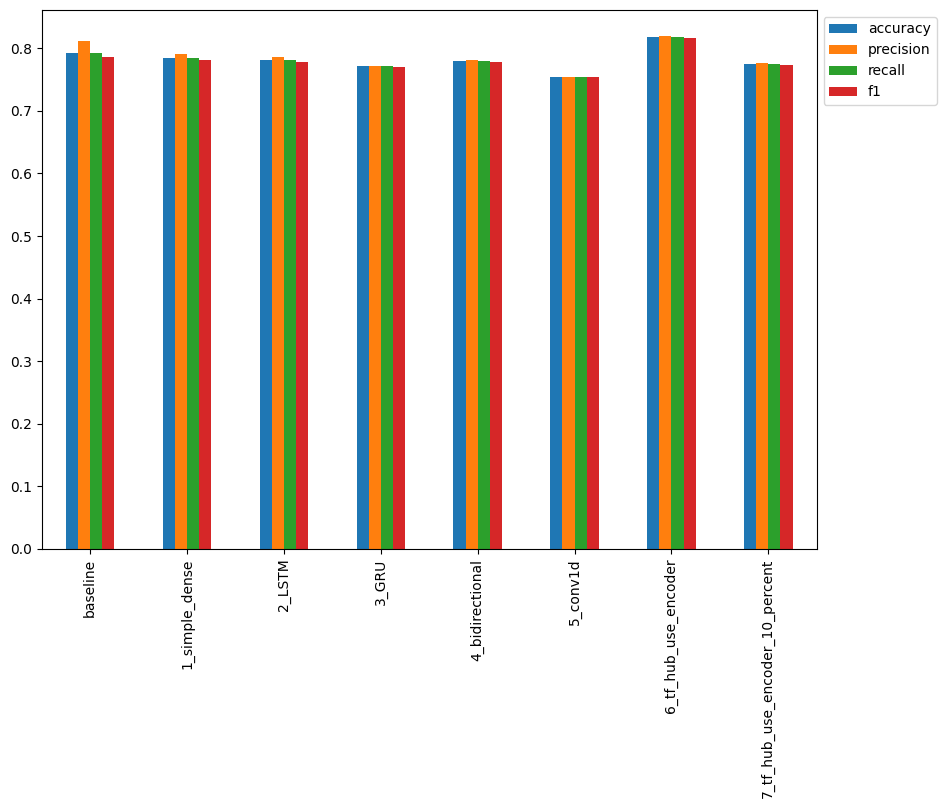

In [107]:
# Plot and compare all of the model results
all_model_results.plot(kind='bar', figsize=(10,7)).legend(bbox_to_anchor=(1.0, 1.0));

In [108]:
# Sort model results by f1-score
all_model_results.sort_values(by='f1', ascending=False)['f1']

6_tf_hub_use_encoder               0.815982
baseline                           0.786219
1_simple_dense                     0.781601
4_bidirectional                    0.777528
2_LSTM                             0.777528
7_tf_hub_use_encoder_10_percent    0.773861
3_GRU                              0.770293
5_conv1d                           0.753301
Name: f1, dtype: float64

<Axes: >

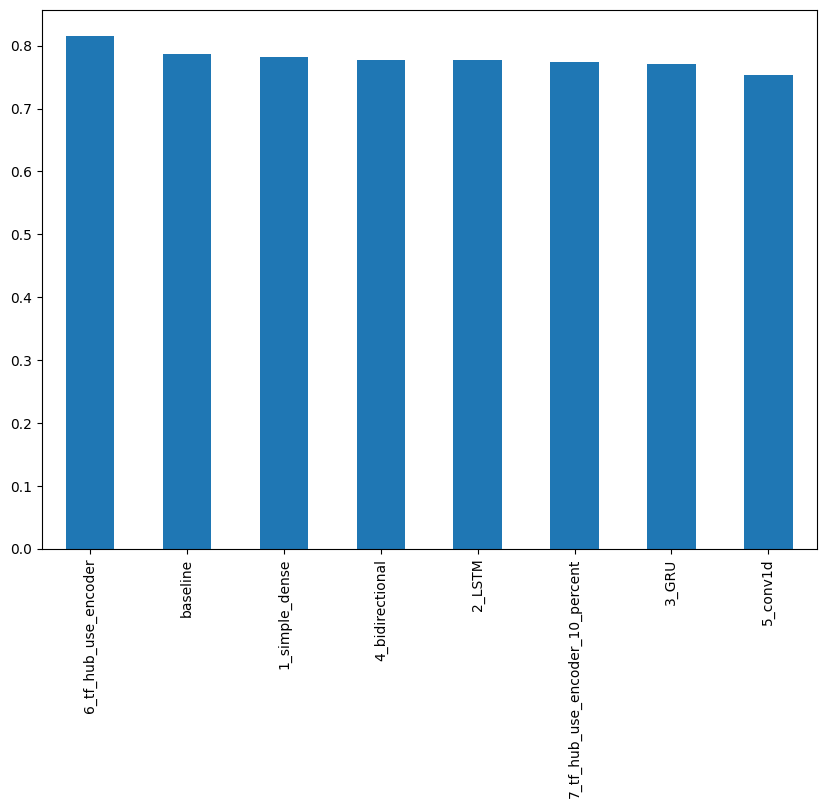

In [109]:
# Plot the f1 score metrics
all_model_results.sort_values(by='f1', ascending=False)['f1'].plot(kind='bar', figsize=(10, 7))

## Saving and loading trained model

There are two main formats to save a model in TensorFlow:
1. HDF5 file format
2. The `SavedModel` format (this is the default when using Tensorflow)

In [110]:
# Save TF Hub Sentence Encoder model to HDF5 format
model_6.save('model_6.h5')

In [111]:
# Load model with custom Hub Layer (required HDF5 format)
loaded_model_6 = tf.keras.models.load_model('model_6.h5',
                                            custom_objects={'KerasLayer': hub.KerasLayer})

In [112]:
# How does our loaded model perform?
loaded_model_6.evaluate(val_sentences, val_labels) # It should be performed as model_6

24/24 [==============================] - 1s 11ms/step - loss: 0.4295 - accuracy: 0.8176


[0.42950183153152466, 0.817585289478302]

In [113]:
# Remind the reuslts of model_6
model_6_results['accuracy']

0.8175853018372703

In [114]:
# As you see results are same but let's check out programatically
np.isclose(model_6_results['accuracy'], loaded_model_6.evaluate(val_sentences, val_labels, verbose=0)[1])

True

Now let's save to the `SavedModel` format...

In [115]:
# Save the model
model_6.save('model_6_SavedModel_format')

In [116]:
# Load in model from SavedModel format
loaded_model_6_SavedModel_format = tf.keras.models.load_model('model_6_SavedModel_format')

In [117]:
# Evaluate model in SavedModel format
loaded_model_6_SavedModel_format.evaluate(val_sentences, val_labels, verbose=0)

[0.42950183153152466, 0.817585289478302]

In [118]:
# Is that close the original model's results?
np.isclose(model_6_results['accuracy'],
           loaded_model_6_SavedModel_format.evaluate(val_sentences, val_labels, verbose=0)[1])

True

## Finding the most wrong examples

* If our best modelstill isn't perfect, what examples is it getting wrong?
* These wrong examples which ones is iy getting most wrong (prediction probabilities closest to the opposite class)

In [120]:
# Make some prediction with loaded model
loaded_model_6_pred_probs = loaded_model_6.predict(val_sentences)
loaded_model_6_pred_probs[:10]

24/24 [==============================] - 0s 9ms/step


array([[0.18815841],
       [0.7506644 ],
       [0.98747605],
       [0.21476707],
       [0.7210393 ],
       [0.678308  ],
       [0.9815992 ],
       [0.97995555],
       [0.9276758 ],
       [0.0977551 ]], dtype=float32)

In [122]:
# Convert predicitons to labels
loaded_model_6_preds = tf.squeeze(tf.round(loaded_model_6_pred_probs))
loaded_model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [133]:
# Create a dataframe with validation sentences and best performing mode predicitons
val_df = pd.DataFrame({'text': val_sentences,
                       'target': val_labels,
                       'prediction': loaded_model_6_preds,
                       'pred_prob': tf.squeeze(loaded_model_6_pred_probs)})

val_df.head()

,text,target,prediction,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.188158
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.750664
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.987476
3,@camilacabello97 Internally and externally scr...,1,0.0,0.214767
4,Radiation emergency #preparedness starts with ...,1,1.0,0.721039


In [136]:
# Find the wrong predictions and sort by prediction probabilities
most_wrong = val_df[val_df['target'] != val_df['prediction']].sort_values('pred_prob', ascending=False)
most_wrong[:20] # most false positives

,text,target,prediction,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.907016
759,FedEx will no longer transport bioterror patho...,0,1.0,0.865253
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.845717
628,@noah_anyname That's where the concentration c...,0,1.0,0.833310
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.821652
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.807167
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.801253
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.786633
119,@freefromwolves GodsLove &amp; #thankU brother...,0,1.0,0.771955
698,åÈMGN-AFRICAå¨ pin:263789F4 åÈ Correction: Ten...,0,1.0,0.768838


Remind the target variables..

* `0` = not diaster
* `1` = diaster

In [139]:
# Most false negatif
most_wrong[-20:]

,text,target,prediction,pred_prob
248,Until my death I'll forever rep the Jets.,1,0.0,0.091744
198,Perspectives on the Grateful Dead: Critical Wr...,1,0.0,0.089139
127,Petition | Heartless owner that whipped horse ...,1,0.0,0.088367
352,@reriellechan HE WAS THE LICH KING'S FIRST CAS...,1,0.0,0.080338
40,@BoyInAHorsemask its a panda trapped in a dogs...,1,0.0,0.080131
486,VICTORINOX SWISS ARMY DATE WOMEN'S RUBBER MOP ...,1,0.0,0.079393
192,New post from @darkreading http://t.co/8eIJDXA...,1,0.0,0.079225
361,Next May I'll be free...from school from oblig...,1,0.0,0.073324
63,I Will Survive by Gloria Gaynor (with Oktavian...,1,0.0,0.072944
681,'The way you move is like a full on rainstorm ...,1,0.0,0.066513


In [144]:
# Check the false positives (model predicted 1 however actual value is 0)
for row in most_wrong[:10].itertuples():
    index, text, target, pred, pred_prob = row
    print(f'Target: {target}, Pred: {pred}, Prob: {pred_prob}')
    print(f'Text:\n{text}\n')
    print(70*'-', '\n')

Target: 0, Pred: 1.0, Prob: 0.9070162773132324
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

---------------------------------------------------------------------- 

Target: 0, Pred: 1.0, Prob: 0.8652527332305908
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

---------------------------------------------------------------------- 

Target: 0, Pred: 1.0, Prob: 0.8457167744636536
Text:
@madonnamking RSPCA site multiple 7 story high rise buildings next to low density character residential in an area that floods

---------------------------------------------------------------------- 

Target: 0, Pred: 1.0, Prob: 0.8333096504211426
Text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

---------------------------------------------------------------------- 

Target: 0, Pred: 1.0, Prob: 0.8216517567634583
Text:
[55436] 1950 LIONEL TRAINS SMOKE LOC

In [146]:
# Check the false negatives (model predicted 0 however actual value is 1)
for row in most_wrong[-10:].itertuples():
    index, text, target, pred, pred_prob = row
    print(f'Target: {target}, Pred: {pred}, Prob: {pred_prob}')
    print(f'Text:\n{text}\n')
    print(70*'-', '\n')

Target: 1, Pred: 0.0, Prob: 0.06333707273006439
Text:
@DavidVonderhaar At least you were sincere ??

---------------------------------------------------------------------- 

Target: 1, Pred: 0.0, Prob: 0.0624820776283741
Text:
Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets

---------------------------------------------------------------------- 

Target: 1, Pred: 0.0, Prob: 0.05569237470626831
Text:
You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

---------------------------------------------------------------------- 

Target: 1, Pred: 0.0, Prob: 0.05550544336438179
Text:
@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu

---------------------------------------------------------------------- 

Target: 1, Pred: 0.0, Prob: 0.05494937673211098
Text

## Making predictions on the test data

In [148]:
# Making prediction on the test dataset and visualizing them
test_sentences = test_df['text'].to_list()
test_sentences[:5]

['Just happened a terrible car crash',
 'Heard about #earthquake is different cities, stay safe everyone.',
 'there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all',
 'Apocalypse lighting. #Spokane #wildfires',
 'Typhoon Soudelor kills 28 in China and Taiwan']

In [152]:
# Create the test samples
test_samples = random.sample(test_sentences, 10)

for test_sample in test_samples:
    pred_prob = tf.squeeze(loaded_model_6.predict([test_sample], verbose=0)) # Our model expects input as a list
    pred = tf.round(pred_prob)
    print(f'Pred: {int(pred)}, Prob: {pred_prob}')
    print(f"Text: \n{test_sample}\n")
    print(70*'-', '\n')

Pred: 0, Prob: 0.13291847705841064
Text: 
We had a room full of people lifting up Collide in prayer!! We are so excited for Friday night!! http://t.co/645dYNAMy8

---------------------------------------------------------------------- 

Pred: 1, Prob: 0.9824036955833435
Text: 
HAPPENING NOW - FDNY RESCUE 1 BLAZING THRU@AND BLASTING THE AIR HORNÛ_ https://t.co/bX6cwRt8M7

---------------------------------------------------------------------- 

Pred: 1, Prob: 0.9507165551185608
Text: 
Stockton Shooting Kills One Officers Investigating: STOCKTON ÛÓ
Stockton police are investigating a shooting t... http://t.co/7vnrB5kurU

---------------------------------------------------------------------- 

Pred: 0, Prob: 0.19483888149261475
Text: 
I've officially been a St. Louisan for one full year. What a crazy awesome overwhelming whirlwind year it has been. Here's to another!

---------------------------------------------------------------------- 

Pred: 1, Prob: 0.7499479651451111
Text: 
Water co

## The speed/score tradeoff

In [163]:
# Let's make a function to measure the time of prediciton
import time

def pred_timer(model, samples):
    """
    Times how long a model takes to make predictions on samples
    """

    start_time = time.perf_counter() # get start time
    model.predict(samples) # make predictions
    end_time = time.perf_counter() # get finish time
    total_time = end_time - start_time # calculate the how long predictions took to make
    time_per_pred = total_time/len(samples)

    return total_time, time_per_pred

In [164]:
# Calculate TF Hub Sentence Encoder time per pred
model_6_total_time, model_6_time_per_pred = pred_timer(model=model_6,
                                                       samples=val_sentences)
model_6_total_time, model_6_time_per_pred

24/24 [==============================] - 0s 11ms/step


(0.3898280330004127, 0.0005115853451448985)

In [165]:
# Calculate the our baselime model times per pred
baseline_total_time, baseline_time_per_pred = pred_timer(model=model_0,
                                                       samples=val_sentences)
baseline_total_time, baseline_time_per_pred

(0.026987432999703742, 3.541657873976869e-05)

In [166]:
# Get the results for pretrained model_6
model_6_results

{'accuracy': 0.8175853018372703,
 'precision': 0.8202616926815424,
 'recall': 0.8175853018372703,
 'f1': 0.8159820561172786}

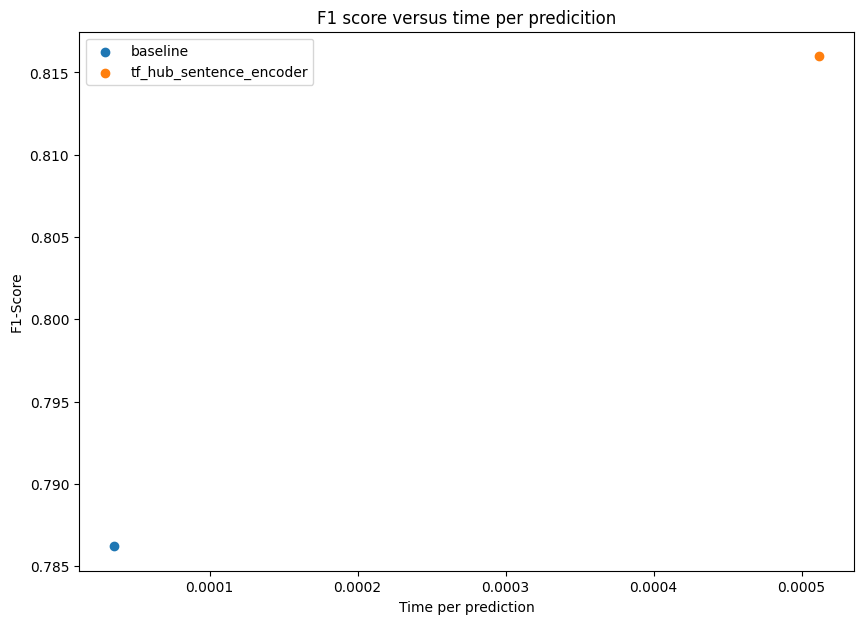

In [168]:
# Plot the speed/performance
plt.figure(figsize=(10, 7))
plt.scatter(baseline_time_per_pred, baseline_results['f1'], label='baseline')
plt.scatter(model_6_time_per_pred, model_6_results['f1'], label='tf_hub_sentence_encoder')
plt.legend()
plt.title('F1 score versus time per predicition')
plt.xlabel('Time per prediction')
plt.ylabel('F1-Score');